# Coursework 

**Initialize packages**

In [2]:
using JuMP, HiGHS, Plots, DataFrames, CSV, Statistics

**Reading Data**

In [3]:
flex_avail = DataFrame(CSV.File("input_files/Flexible_load_availability.csv"));

In [6]:
generators = DataFrame(CSV.File("input_files/Generators_data.csv"));


In [ ]:
new_col_names = string.(generators.R_ID);  # Convert to String


In [3]:
gen_var = DataFrame(CSV.File("input_files/Generators_variability.csv"));
gen_var=gen_var[:,2:39];

In [ ]:
load = DataFrame(CSV.File("input_files/Load_data.csv"));
load=load[:,9:15];

In [9]:
network = DataFrame(CSV.File("input_files/Network.csv"));

### Problem formulation
The objective function will be:
$\begin{align}
\min &\sum_{g \in Gen} FixedCost_g \times CAP_g + \sum_{g\in Gen}\sum_{h \in H} VarCost_g \times GEN_{g,h} +\\[6pt]
&\quad\quad \sum_{h \in H} NSECost \times NSE_h  + \sum_{s \in Storage} FixedCost_s \times CAP_s \\[6pt]
\end{align}$

$\begin{align}
\ FixedCost_g = Investment_g + FixedOM_g\\[6pt]
\ VarCost_g = VarOM_g + FuelCost_g \times HeatRate_g \\[6pt]
\ FixedCost_s = Investment_s + FixedOM_s\\[6pt]
\end{align}$

Variables
$\begin{align}
&\text{Capacity variable only for new build:}&\\[6pt]
& CAP_{g} \geq 0 & \forall \quad g \in Generators\\[6pt]
&\text{Capacity variable for Storage:}&\\[6pt]
& 0 \leq CAP_s \leq 100 MW & \forall \quad s \in Storage\\[6pt]
&\text{Generation variable:}&\\[6pt]
& GEN_{g,h} \geq 0 & \forall \quad g \in NEW_{GEN}  ,  & \forall \quad h \in Hours \\[6pt]
&\text{Not Served Energy:}&\\[6pt]
& NSE_{h} \geq 0 & \forall \quad h \in H \\[6pt]
&\text{Flow variable:}&\\[6pt]
& FLOW_{l,h} & \forall \quad l \in Transmission_{Lines}  ,  & \forall \quad h \in Hours\\[6pt]
&\text{Discharge variable:}&\\[6pt]
& DISCHARGE_{s,h} \geq 0 & \forall \quad s \in Storage  ,  & \forall \quad h \in Hours\\[6pt]
&\text{Charge variable:}&\\[6pt]
& CHARGE_{s,h} \geq 0 & \forall \quad s \in Storage  ,  & \forall \quad h \in Hours\\[6pt]
&\text{State of Charge variable:}&\\[6pt]
& 0\% \leq SOC_{s,h} \leq 100\%  & \forall \quad s \in Storage  ,  & \forall \quad h \in Hours\\[6pt]
&\text{Demand that was originally at hour h has shifted to time h’}\\[6pt]
& d_{h,k,z} \geq 0 & \forall \quad h \in H, \quad k \in \{h, \min(h+5, \max(H))\}, \quad z \in N \\[6pt]
\end{align}$

**SETS**

$\begin{align}
& N & \text{Set for zones [1:6]}\\[6pt]
& L & \text{Set for Transmission Lines [1:10]}\\[6pt]
& H  &  \text{Set of hours in the year [1:8736]}\\[6pt]
& H_2 & \text{Set of hours for Storage Operation [2:8736]}\\[6pt]
& Storage & \text{Set for storage[6 batteries, one per zone]}\\[6pt]
& Gen & \text{Set for generators }\\[6pt]
& Id_{STORAGE} & \text{Set for storage Id}\\[6pt]
& Id_{Gen} & \text{Set for Gen Id }\\[6pt]
& Zone & \text{Set for zones [1:6]}\\[6pt]
\end{align}$

s.t. the constraints
$\begin{align}
&\text{Capacity constraint for nuclear:}&\\[6pt]
& GEN_{Nuclear,h} = CAP_{Nuclear} & \forall h \in H\\[6pt]
&\text{Capacity constraint for new generators:}&\\[6pt]
& 0 \leq  GEN_{g,h} \leq CAP_g \times CF_{g,h} & \forall \quad g \in GEN, h \in H\\[6pt]
&\text{Supply demand balance constraint:}&\\[6pt]
&\sum_{g \in Gen} GEN_{g,h,i} - (Demand_{h,i} - Flexible_{Demand_h,i})+ \sum_{s \in Storage} (DISCHARGE_{s,h,i} -CHARGE_{s,h,i} ) + &\\
& NSE_{h,i}  - \sum\limits_{k=h-5}^{h} d_{k,h,i}  = \sum_{j \in J_i} FLOW_{ij} & \forall \quad i \in \text{N} &, & \forall \quad h \in \text{H}\\
&\text{Thermal limit constraint:}&\\[6pt]
& |FLOW_{ij}| \leq MaxFlow_{ij} & \forall \quad i \in \text{N} &, & \forall j \in J_i \\
&\text{Flow direction constraint:}&\\[6pt]
& FLOW_{ij} = - FLOW_{ji} & \forall \quad i, j \in \text{N} \\
&\text{State of Charge constraint:}&\\[6pt]
& SOC_{s,h}=SOC_{s,h-1} + \big(CHARGE_{s,h} * Eff_s - \frac{DISCHARGE_{s,h}}{Eff_s}\big)  & \forall \quad s \in Storage, h \in H_2 \\[6pt]
&\text{Initial and Fianl State of Charge constraint:}&\\[6pt]
& SOC_{s,1} = SOC_{s,t_{end}} = 50\% *SOC_{s}^{max}& \forall \quad s \in Storage\\[6pt]
&\text{Disharge Rate constraint:}&\\[6pt]
& 0 \leq DISCHARGE_{s,h} \leq \frac{CAP_s}{10}  & \forall \quad s \in Storage,  h \in H\\[6pt]
&\text{Charge Rate constraint:}&\\[6pt]
& 0 \leq CHARGE_{s,h} \leq  \frac{CAP_s}{10}  & \forall \quad s \in Storage,  h \in H\\[6pt]
&\text{State of Charge constraint:}&\\[6pt]
& 0 \leq SOC_{s,h} \leq SOC_{s}^{max}& \forall \quad s \in Storage, h \in H\\[6pt]
&\text{\underline{EVs Flexibility constraint:}}&\\[6pt]
& \sum\limits_{k=h}^{h+5} I_{h,k}\times d_{k,h,i} = Flexible_{Demand{|h,i}} & \forall \quad i \in \text{N}& , & \forall \quad h \in \text{H}
\end{align}$

**SETS**

**Parameters**
- $Investment_g$ annuitized capacity of Generator $g$ investment cost (annual cost, $/MW-year)
- $Investment_s$ annuitized capacity of Storage $s$ investment cost (annual cost, $/MW-year)
- $FixedOM_g$, the fixed operations and maintenance cost of Generator $g$(\$/MW-year)
- $FixedOM_s$, the fixed operations and maintenance cost of Storage $s$(\$/MW-year)
- $VarOM_g$, the variable operations and maintenance cost (\$/MWh);
- $HeatRate_g$, the rate of fuel consumed per unit of electricity produced (MMBtu/MWh);
- $FuelCost_g$, the cost of fuel (\$/MMBtu)
- $NSECost$, the opportunity cost or penalty incurred for involuntary non-served energy (\$/MWh); and
- $Demand_h$, is the demand in each hour (MW).
- $MaxFlow_{ij}$, the maximum allowable flow along the line from $i$ to $j$ (MW)
- $CF_{g,h}$, hourly profile of Generator $g$ (per unit).
- $Eff_s$, efficiency of the charge/discharge cycle.
- $SOC^{max}$, maximum storage capacity (MW).
- $I_{h,k}$, Parameter that is 1 if h $\leq$ k $\leq$ h+5 for h in H; 0 otherwise. Used for flexibility.

**CASE 1: NO FLEXIBILITY**

**Sets**

In [25]:
N=[1,2,3,4,5,6]; #zones
L=[1,2,3,4,5,6,7,8,9,10];

In [26]:
# The set of hours in the demand DataFrame
H = load.Time_index; # same for every zone

In [27]:
H_2 = H[2:end];

In [28]:
# Storage
storage = generators[generators.Resource .== "battery", :];

In [29]:
gen = generators[generators.Resource .!= "battery", :];

In [31]:
rename!(gen_var, new_col_names);

In [32]:
var_new = gen_var[:,string.(gen.R_ID)];

In [33]:
Id_storage=storage.R_ID;
Id_gen=gen.R_ID;
Zone_gen=gen.Zone;





In [34]:
# Define the Incident Matrix
A = [
    1   -1   0    0    0    0;
    1    0  -1    0    0    0;
    0    1  -1    0    0    0;
    0    1   0   -1    0    0;
    0    0   1   -1    0    0;
    0    0   0    1   -1    0;
    0    0   0    1    0   -1;
    1    0   0    0   -1    0;
    0    1   0    0   -1    0;
    0    0   1    0   -1    0
];

**Model**

In [35]:
Flex_Model = Model(HiGHS.Optimizer) # using the HiGHS open source solver

A JuMP Model
├ solver: HiGHS
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

**Variables**

In [36]:
# Indicator Function: 1 if t' is within (t, t+5), 0 otherwise
I = Dict((h, k) => (h ≤ k ≤ h+5 ? 1 : 0) for h in H, k in H);

In [37]:
##TEST


@variables(Flex_Model, begin
    # Generating capacity (MW)
   CAP[g in Id_gen] >= 0
    # Storage capacity (MW)
    100 >= CAP_stor[s in Id_storage] >= 0
    
    # Generation in each hour (MWh)
    GEN[g in Id_gen, h in H] >= 0
    
    # Non-served energy in each hour (MWh) – currently uses zones 1:6
    NSE[h in H, z in N] >= 0
    
    # Flow
    FLOW[l in L, h in H]
    
    # Storage operations (charge/discharge in MW, SOC in MWh)
    
    0 <= DISCHARGE[s in Id_storage, h in H]
    0 <= CHARGE[s in Id_storage, h in H]    
    0 <= SOC[s in Id_storage, h in H]       

    #Flexible demand
    
    0<= d[h in H, k in h:min(h+5, maximum(H)), z in N]  # Demand shift variable
end);



In [ ]:
@constraints(Flex_Model, begin

#NuclearInflexibility[id in Id_gen,h in H; gen[gen.R_ID.==id, :Resource]== "nuclear"], GEN[id,h] == CAP[id];   #States inflexibility of nuclear plants
NuclearInflexibility[id in Id_gen ∩ gen[gen.Resource .== "nuclear", :R_ID], h in H], GEN[id, h] == CAP[id]

Generation[id in Id_gen,h in H], GEN[id,h]<=CAP[id] * var_new[h,string(id)]   

#Supply demand balance
cBalance1[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 1,:R_ID]) - (load.Load_MW_z1[h]-flex_avail.ev_load_shifting_z1[h]) +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==1,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==1,:R_ID]) + NSE[h,1] -sum(d[k,h,1] for k in max(1, h-5):h)== sum(A[l,1]*FLOW[l,h] for l in L) ;  
cBalance2[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 2,:R_ID]) - (load.Load_MW_z2[h]-flex_avail.ev_load_shifting_z2[h]) +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==2,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==2,:R_ID]) + NSE[h,2] -sum(d[k,h,2] for k in max(1, h-5):h)== sum(A[l,2]*FLOW[l,h] for l in L) ;   
cBalance3[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 3,:R_ID]) - (load.Load_MW_z3[h]-flex_avail.ev_load_shifting_z3[h]) +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==3,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==3,:R_ID]) + NSE[h,3] -sum(d[k,h,3] for k in max(1, h-5):h)== sum(A[l,3]*FLOW[l,h] for l in L) ;
cBalance4[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 4,:R_ID]) - (load.Load_MW_z4[h]-flex_avail.ev_load_shifting_z4[h]) +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==4,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==4,:R_ID]) + NSE[h,4] -sum(d[k,h,4] for k in max(1, h-5):h)== sum(A[l,4]*FLOW[l,h] for l in L) ;  
cBalance5[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 5,:R_ID]) - (load.Load_MW_z5[h]-flex_avail.ev_load_shifting_z5[h]) +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==5,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==5,:R_ID]) + NSE[h,5] -sum(d[k,h,5] for k in max(1, h-5):h)== sum(A[l,5]*FLOW[l,h] for l in L) ;  
cBalance6[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 6,:R_ID]) - (load.Load_MW_z6[h]-flex_avail.ev_load_shifting_z6[h]) +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==6,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==6,:R_ID]) + NSE[h,6] -sum(d[k,h,6] for k in max(1, h-5):h)== sum(A[l,6]*FLOW[l,h] for l in L) ;

 #Thermal constraint
Positive_max_flow[l in L, h in H], FLOW[l,h] <= network[l,:Line_Max_Flow_MW]
Negative_max_flow[l in L, h in H], FLOW[l,h] >= -network[l,:Line_Max_Flow_MW]


#State of charge
StateOfCharge[s in Id_storage, h in H_2], SOC[s,h] == SOC[s,h-1] + storage[storage.R_ID.==s,:Charge_efficiency][1]*CHARGE[s,h] - DISCHARGE[s,h]/storage[storage.R_ID.==s,:Discharge_efficiency][1] # State of charge of storage units

StateOfcharge_ini[s in Id_storage], SOC[s,1].==0.5*CAP_stor[s].*storage.Max_Duration[storage.R_ID.==s] #States initial condition for SOC level (assumes half SOC)

StateOfcharge_end[s in Id_storage], SOC[s,8736].==0.5*CAP_stor[s].*storage.Max_Duration[storage.R_ID.==s] #States final condition for SOC level (assumes half SOC)

# Storage operations (charge/discharge in MW, SOC in MWh)
limitdis[s in Id_storage, h in H], DISCHARGE[s,h] <= CAP_stor[s]/10
limitcha[s in Id_storage, h in H], CHARGE[s,h]<= CAP_stor[s]/10
limitSOC[s in Id_storage, h in H], SOC[s,h] .<= CAP_stor[s].*storage.Max_Duration[storage.R_ID.==s]

#Flexibility
flexibility1[h in H], sum(I[h,k] * d[h,k,1] for k in h:min(h+5, maximum(H))) == flex_avail.ev_load_shifting_z1[h]
flexibility2[h in H], sum(I[h,k] * d[h,k,2] for k in h:min(h+5, maximum(H))) == flex_avail.ev_load_shifting_z2[h]
flexibility3[h in H], sum(I[h,k] * d[h,k,3] for k in h:min(h+5, maximum(H))) == flex_avail.ev_load_shifting_z3[h]
flexibility4[h in H], sum(I[h,k] * d[h,k,4] for k in h:min(h+5, maximum(H))) == flex_avail.ev_load_shifting_z4[h]
flexibility5[h in H], sum(I[h,k] * d[h,k,5] for k in h:min(h+5, maximum(H))) == flex_avail.ev_load_shifting_z5[h]
flexibility6[h in H], sum(I[h,k] * d[h,k,6] for k in h:min(h+5, maximum(H))) == flex_avail.ev_load_shifting_z6[h]

end);

In [39]:
#println(NoFlex_Model[:cBalance1]);

**Objective function**

In [40]:
@objective(Flex_Model,Min,
#=
sum(
(sum(gen[gen.R_ID.==id, :Inv_cost_per_MWyr])+sum(gen[gen.R_ID.==id, :Fixed_OM_cost_per_MWyr]))*CAP[id]+
sum(sum(gen[gen.R_ID.==id,:Var_OM_cost_per_MWh] .+ sum(gen[gen.R_ID.==id,:Heat_rate_MMBTU_per_MWh].*gen[gen.R_ID.==id,:Cost_per_MMBtu]))
*GEN[id,h] for h in H) for id in Id_gen)+
sum(NSE[h, z] for h in H, z in N)*9000
)
=#


sum(
(sum(gen[gen.R_ID.==id, :Inv_cost_per_MWyr])+sum(gen[gen.R_ID.==id, :Fixed_OM_cost_per_MWyr]))*CAP[id]+
sum(sum(gen[gen.R_ID.==id,:Var_OM_cost_per_MWh] .+ sum(gen[gen.R_ID.==id,:Heat_rate_MMBTU_per_MWh].*gen[gen.R_ID.==id,:Cost_per_MMBtu]))
*GEN[id,h] for h in H) for id in Id_gen)+
sum(NSE[h, z] for h in H, z in N)*9000+
sum((sum(storage[storage.R_ID.==id_s,:Inv_cost_per_MWyr]).+sum(storage[storage.R_ID.==id_s,:Fixed_OM_cost_per_MWyr]))*CAP_stor[id_s] for id_s in Id_storage)
)


245527.198 CAP[47] + 40.75520000000001 GEN[47,1] + 40.75520000000001 GEN[47,2] + 40.75520000000001 GEN[47,3] + 40.75520000000001 GEN[47,4] + 40.75520000000001 GEN[47,5] + 40.75520000000001 GEN[47,6] + 40.75520000000001 GEN[47,7] + 40.75520000000001 GEN[47,8] + 40.75520000000001 GEN[47,9] + 40.75520000000001 GEN[47,10] + 40.75520000000001 GEN[47,11] + 40.75520000000001 GEN[47,12] + 40.75520000000001 GEN[47,13] + 40.75520000000001 GEN[47,14] + 40.75520000000001 GEN[47,15] + 40.75520000000001 GEN[47,16] + 40.75520000000001 GEN[47,17] + 40.75520000000001 GEN[47,18] + 40.75520000000001 GEN[47,19] + 40.75520000000001 GEN[47,20] + 40.75520000000001 GEN[47,21] + 40.75520000000001 GEN[47,22] + 40.75520000000001 GEN[47,23] + 40.75520000000001 GEN[47,24] + 40.75520000000001 GEN[47,25] + 40.75520000000001 GEN[47,26] + 40.75520000000001 GEN[47,27] + 40.75520000000001 GEN[47,28] + 40.75520000000001 GEN[47,29] + [[...209642 terms omitted...]] + 9000 NSE[8733,1] + 9000 NSE[8733,2] + 9000 NSE[8733,3] +

In [41]:
optimize!(Flex_Model)

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-04, 1e+01]
  Cost   [1e+01, 7e+05]
  Bound  [1e+02, 1e+02]
  RHS    [1e+02, 5e+04]
Presolving model
531357 rows, 828335 cols, 2170485 nonzeros  0s
531357 rows, 828335 cols, 2170485 nonzeros  1s
Presolve : Reductions: rows 531357(-272361); columns 828335(-62685); elements 2170485(-370002)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -3.1788451264e+01 Pr: 104820(7.87944e+08) 2s
      85826     2.9293796960e+10 Pr: 110093(1.01653e+09); Du: 0(1.48566e-05) 7s
     109419     3.6867941485e+10 Pr: 105442(5.11234e+08); Du: 0(1.31869e-05) 14s
     128081     4.4905848423e+10 Pr: 109277(1.04262e+09); Du: 0(1.222e-05) 19s
     143806     4.9022262009e+10 Pr: 102052(6.13775e+08); Du: 0(1.22958e-05) 24s
     156567     5.2096481193e+10 Pr: 83646(1.68159e+08); Du: 0(1.2925e-05) 29s
    

In [42]:

#print(load.Load_MW_z1)

In [43]:
# Create an empty array to store results
d_values = []

# Iterate over the decision variable d
for h in H
    for k in h:min(h+5, maximum(H))
        for z in N
            push!(d_values, (h, k, z, value(d[h, k, z])))
        end
    end
end

# Convert into a DataFrame
df_d = DataFrame(h = [x[1] for x in d_values], 
                 k = [x[2] for x in d_values], 
                 z = [x[3] for x in d_values], 
                 d_value = [x[4] for x in d_values])

# Show the DataFrame
println(df_d)


Excessive output truncated after 10485760 bytes.

In [44]:
#println(first(df_d, 40));  # Show first 10 rows


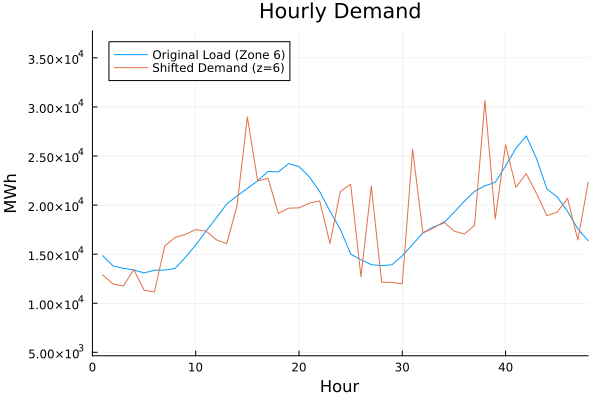

In [45]:
# Aggregate total demand shifts per hour
df_time_series = combine(groupby(df_d, :h), :d_value => sum => :total_d_shift)

# Filter data for zone z=2
df_d_z6 = filter(row -> row.z == 6, df_d)
df_d_z6 = combine(groupby(df_d_z6, :k), :d_value => sum => :d_value)

#println(df_grouped_by_k6)  # Show grouped data


# Plot original load
plot(load.Load_MW_z6, xlims=(0,48), label="Original Load (Zone 6)")

# Plot shifted load
plot!(df_d_z6.k,load.Load_MW_z6-flex_avail.ev_load_shifting_z6+df_d_z6.d_value, xlims=(0,48), label="Shifted Demand (z=6)")

# Labels and Title
title!("Hourly Demand")
xlabel!("Hour")
ylabel!("MWh")
#println(first(df_d_z6, 10))  # Show first 10 rows
#print((last(df_d_z6)))



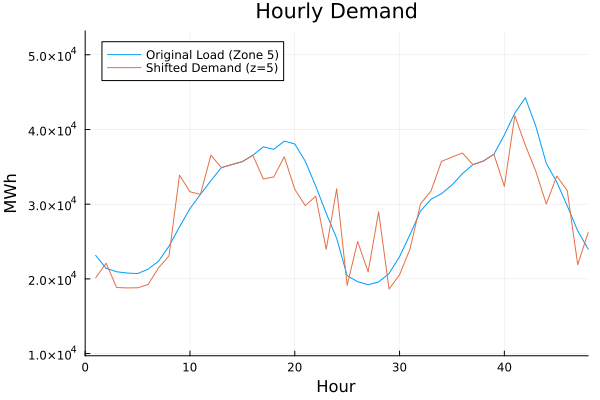

In [46]:
# Aggregate total demand shifts per hour
df_time_series = combine(groupby(df_d, :h), :d_value => sum => :total_d_shift)

# Filter data for zone z=2
df_d_z5 = filter(row -> row.z == 5, df_d)

df_d_z5 = combine(groupby(df_d_z5, :k), :d_value => sum => :d_value)

#println(df_grouped_by_k5)  # Show grouped data


# Plot original load
plot(load.Load_MW_z5, xlims=(0,48), label="Original Load (Zone 5)")

# Plot shifted load
plot!(df_d_z5.k,load.Load_MW_z5-flex_avail.ev_load_shifting_z5+df_d_z5.d_value, xlims=(0,48), label="Shifted Demand (z=5)")

# Labels and Title
title!("Hourly Demand")
xlabel!("Hour")
ylabel!("MWh")

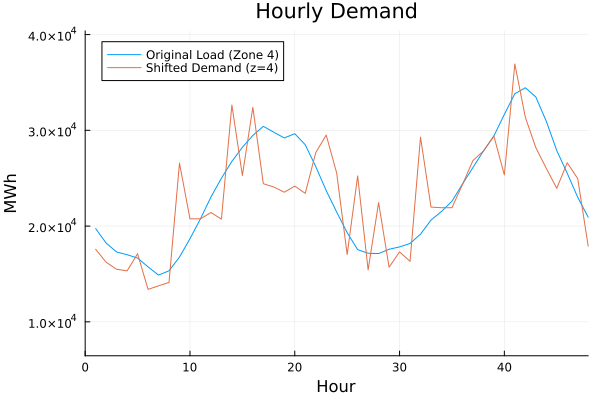

In [47]:
# Aggregate total demand shifts per hour
df_time_series = combine(groupby(df_d, :h), :d_value => sum => :total_d_shift)

# Filter data for zone z=2
df_d_z4 = filter(row -> row.z == 4, df_d)

df_d_z4 = combine(groupby(df_d_z4, :k), :d_value => sum => :d_value)

#println(df_grouped_by_k4)  # Show grouped data

# Plot original load
plot(load.Load_MW_z4, xlims=(0,48), label="Original Load (Zone 4)")

# Plot shifted load
plot!(df_d_z4.k,load.Load_MW_z4-flex_avail.ev_load_shifting_z4+df_d_z4.d_value, xlims=(0,48), label="Shifted Demand (z=4)")

# Labels and Title
title!("Hourly Demand")
xlabel!("Hour")
ylabel!("MWh")

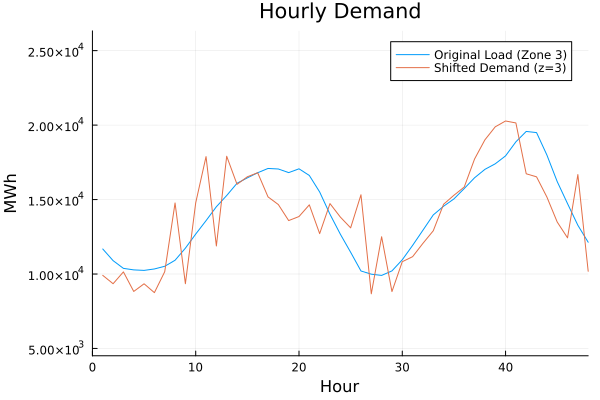

In [48]:
# Aggregate total demand shifts per hour
df_time_series = combine(groupby(df_d, :h), :d_value => sum => :total_d_shift)

# Filter data for zone z=2
df_d_z3 = filter(row -> row.z == 3, df_d)

df_d_z3 = combine(groupby(df_d_z3, :k), :d_value => sum => :d_value)

#println(df_grouped_by_k3)  # Show grouped data


# Plot original load
plot(load.Load_MW_z3, xlims=(0,48), label="Original Load (Zone 3)")

# Plot shifted load
plot!(df_d_z3.k,load.Load_MW_z3-flex_avail.ev_load_shifting_z3+df_d_z3.d_value, xlims=(0,48), label="Shifted Demand (z=3)")

# Labels and Title
title!("Hourly Demand")
xlabel!("Hour")
ylabel!("MWh")

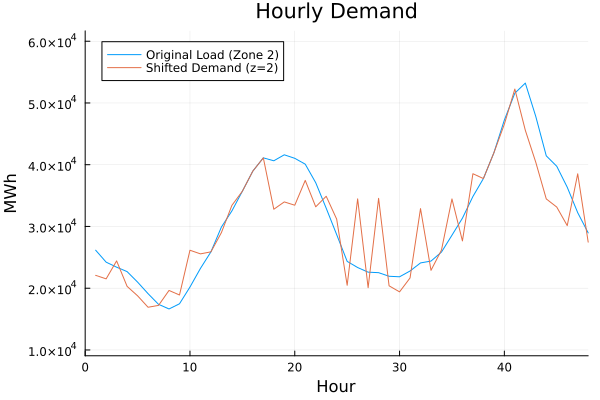

In [49]:
# Aggregate total demand shifts per hour
df_time_series = combine(groupby(df_d, :h), :d_value => sum => :total_d_shift)

# Filter data for zone z=2
df_d_z2 = filter(row -> row.z == 2, df_d)

df_d_z2 = combine(groupby(df_d_z2, :k), :d_value => sum => :d_value)

#println(df_grouped_by_k2)  # Show grouped data

# Plot original load
plot(load.Load_MW_z2, xlims=(0,48), label="Original Load (Zone 2)")

# Plot shifted load
plot!(df_d_z2.k,load.Load_MW_z2-flex_avail.ev_load_shifting_z2+df_d_z2.d_value, xlims=(0,48), label="Shifted Demand (z=2)")

# Labels and Title
title!("Hourly Demand")
xlabel!("Hour")
ylabel!("MWh")

In [50]:
# Aggregate total demand shifts per hour
df_time_series = combine(groupby(df_d, :h), :d_value => sum => :total_d_shift)

# Filter data for zone z=2
df_d_z1 = filter(row -> row.z == 1, df_d)

df_d_z1 = combine(groupby(df_d_z1, :k), :d_value => sum => :d_value)

#println(df_grouped_by_k1)  # Show grouped data


# Plot original load
plot(load.Load_MW_z1, xlims=(0,48), label="Original Load (Zone 1)")

# Plot shifted load
plot!(df_d_z1.k,load.Load_MW_z1-flex_avail.ev_load_shifting_z1+df_d_z1.d_value, xlims=(0,48), label="Shifted Demand (z=1)")

# Labels and Title
title!("Hourly Demand")
xlabel!("Hour")
ylabel!("MWh")
size(df_d)

(314406, 4)

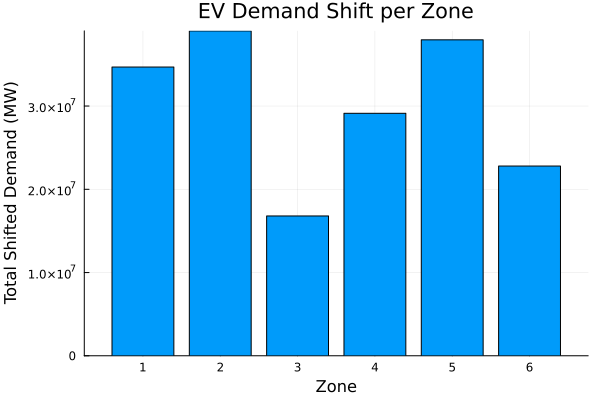

In [51]:
# Aggregate demand shifts per zone
df_zone = combine(groupby(df_d, :z), :d_value => sum => :total_d_shift)

# Bar chart
bar(df_zone.z, df_zone.total_d_shift, 
    xlabel="Zone", ylabel="Total Shifted Demand (MW)",
    title="EV Demand Shift per Zone",
    legend=false)


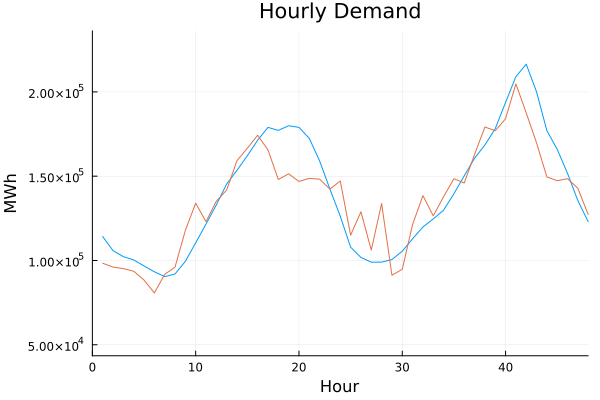

In [52]:
plot(load.Load_MW_z1+load.Load_MW_z2+load.Load_MW_z3+load.Load_MW_z4+load.Load_MW_z5+load.Load_MW_z6, xlims=(0,48) ,label="")
plot!(load.Load_MW_z1+load.Load_MW_z2+load.Load_MW_z3+load.Load_MW_z4+load.Load_MW_z5+load.Load_MW_z6-
flex_avail.ev_load_shifting_z1-flex_avail.ev_load_shifting_z2-flex_avail.ev_load_shifting_z3-flex_avail.ev_load_shifting_z4-flex_avail.ev_load_shifting_z5-flex_avail.ev_load_shifting_z6+
df_d_z1.d_value+df_d_z2.d_value+df_d_z3.d_value+df_d_z4.d_value+df_d_z5.d_value+df_d_z6.d_value, xlims=(0,48) ,label="")
title!("Hourly Demand")
xaxis!("Hour")
yaxis!("MWh")


In [53]:
#=
plot(load.Load_MW_z1+load.Load_MW_z2+load.Load_MW_z3+load.Load_MW_z4+load.Load_MW_z5+load.Load_MW_z6
-flex_avail.ev_load_shifting_z1-flex_avail.ev_load_shifting_z2-flex_avail.ev_load_shifting_z3-flex_avail.ev_load_shifting_z4-flex_avail.ev_load_shifting_z5-flex_avail.ev_load_shifting_z6
+df_d_z1.d_value[:,4]#+df_d_z2.d_value+df_d_z3.d_value+df_d_z4.d_value+df_d_z5.d_value+df_d_z6.d_value
, xlims=(0,48) ,label="")
=#

In [54]:

# Extract capacity values for each generator
gen_capacities = [(g, value(CAP[g])) for g in Id_gen]

# Convert to a DataFrame for better visualization
df_gen_capacities = DataFrame(generator=first.(gen_capacities), capacity=last.(gen_capacities))

# Print the capacity values
println(df_gen_capacities)


32×2 DataFrame
 Row │ generator  capacity 
     │ Int64      Float64  
─────┼─────────────────────
   1 │        47     -0.0
   2 │        48  31135.0
   3 │        49      0.0
   4 │        54      0.0
   5 │        60      0.0
   6 │        61  26168.2
   7 │        62      0.0
   8 │        65  11162.6
   9 │        77      0.0
  10 │        79   8594.36
  11 │        85  17962.0
  12 │        94   5057.17
  13 │        96  33997.4
  14 │        97  11533.3
  15 │       104  23414.3
  16 │       117      0.0
  17 │       118      0.0
  18 │       120  10142.5
  19 │       121      0.0
  20 │       124  17825.4
  21 │       126  18657.6
  22 │       128  16547.4
  23 │       129   8850.49
  24 │       136  16115.1
  25 │       142      0.0
  26 │       143      0.0
  27 │       156     -0.0
  28 │       157   8182.58
  29 │       158   4000.8
  30 │       159     -0.0
  31 │       160  14828.4
  32 │       161   3572.41


In [ ]:
# Extract generation values for each generator and hour
########################################################

# Create empty arrays to store generator, hour, and generation values
generators = Int[]
hours = Int[]
generation_values = Float64[]

# Loop through each generator and hour, and store values
for g in Id_gen
    for h in H
        push!(generators, g)
        push!(hours, h)
        push!(generation_values, value(GEN[g, h]))
    end
end

# Create DataFrame from the collected values
df_gen_values = DataFrame(generator=generators, hour=hours, generation=generation_values)

# Print first 10 rows to verify
#println(first(df_gen_values, 10))

#######################################################

#PLOT OF GENERATION
using Plots
# Create a plot
plot(xlims=(0,48))

# Loop through each generator and plot its generation over time
for g in unique(df_gen_values.generator)
    gen_data = df_gen_values[df_gen_values.generator .== g, :]
    plot!(gen_data.hour, gen_data.generation, label="Gen $g", linewidth=2)
end

# Labels and title
xlabel!("Hour")
ylabel!("Generation (MWh)")
title!("Generation Over Time for Each Generator")
#legend(:topright)  # Adjust legend position





In [ ]:
# Extract storage capacities
stor_capacities = [(s, value(CAP_stor[s])) for s in Id_storage]

# Convert to a DataFrame
df_stor_capacities = DataFrame(storage_unit=first.(stor_capacities), 
                               capacity=last.(stor_capacities))

# Print the storage capacities
println(df_stor_capacities)

6×2 DataFrame
 Row │ storage_unit  capacity 
     │ Int64         Float64  
─────┼────────────────────────
   1 │           58     100.0
   2 │           75     100.0
   3 │           93     100.0
   4 │          116     100.0
   5 │          125     100.0
   6 │          141     100.0


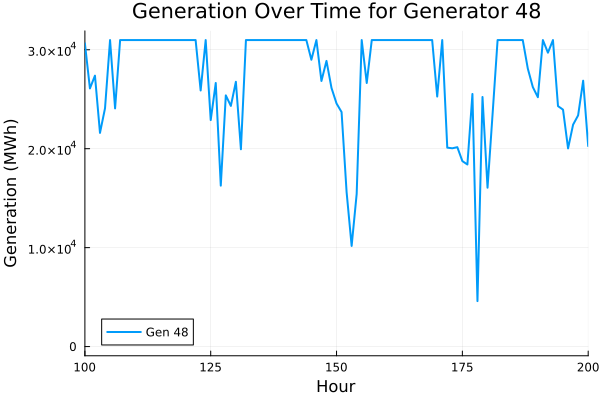

In [ ]:


# Filter for generator with ID 48
gen_data = df_gen_values[df_gen_values.generator .== 48, :]

# Create plot
plot(gen_data.hour, gen_data.generation, label="Gen 48", linewidth=2, xlims=(100,200))

# Labels and title
xlabel!("Hour")
ylabel!("Generation (MWh)")
title!("Generation Over Time for Generator 48")


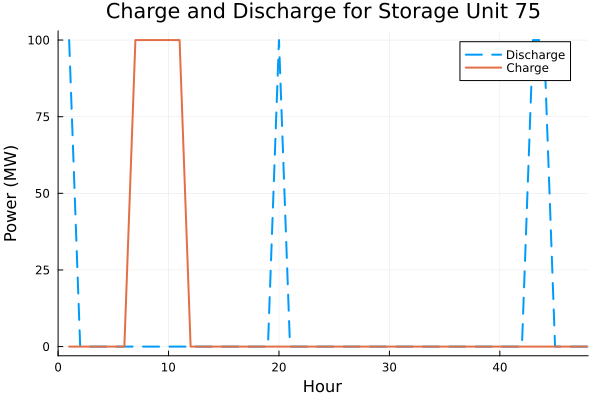

In [ ]:


# Storage unit ID
s_id = 75  

# Create empty vectors
discharge_values = Float64[]
charge_values = Float64[]
hours = Int[]

# Loop through each hour to extract discharge and charge values
for h in H
    push!(discharge_values, value(DISCHARGE[s_id, h]))  # Store discharge values
    push!(charge_values, value(CHARGE[s_id, h]))        # Store charge values
    push!(hours, h)  # Store the corresponding hour
end

# Create a plot
plot(hours, discharge_values, label="Discharge", linewidth=2, linestyle=:dash, xlims=(0, 48))
plot!(hours, charge_values, label="Charge", linewidth=2, linestyle=:solid)

# Add labels and title
xlabel!("Hour")
ylabel!("Power (MW)")
title!("Charge and Discharge for Storage Unit $s_id")


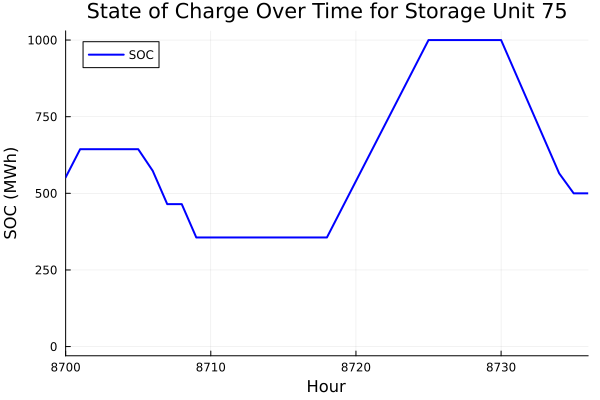

In [ ]:
# Storage unit ID (Change as needed)
s_id = 75;  

# Create empty vectors for SOC and hours
soc_values = Float64[]
hours = Int[]

# Loop through each hour to extract SOC values for storage unit 's_id'
for h in H
    push!(soc_values, value(SOC[s_id, h]))  # Store SOC values
    push!(hours, h)  # Store the corresponding hour
end

# Create a plot
plot(hours, soc_values, label="SOC", linewidth=2, linestyle=:solid, color=:blue, xlims=(8700, maximum(H)))

# Add labels and title
xlabel!("Hour")
ylabel!("SOC (MWh)")
title!("State of Charge Over Time for Storage Unit $s_id")
